In [3]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp

In [4]:
# Load FER2013 CSV
data = pd.read_csv('../Data/fer2013.csv')

# Extract pixel data and reshape it into images
pixels = data['pixels'].tolist()
images = [np.array([int(pixel) for pixel in pixel_sequence.split()]).reshape(48, 48) for pixel_sequence in pixels]

In [5]:
def parse_landmarks(landmarks_str):
    # Assuming landmarks are stored as comma-separated values
    landmarks = landmarks_str.split(',')
    
    # Convert the list of strings into floats
    landmarks = np.array([float(l) for l in landmarks])
    
    # Reshape into 468 points with 2 coordinates (x, y) (468 is the number of landmarks in MediaPipe's Face Mesh)
    return landmarks.reshape(468, 2)

In [6]:
# Initialize Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

face_landmarks_list = []
successful_indices = []  # To track indices of successful landmark extractions

for idx, image in enumerate(images):
    # Convert the image from 32-bit to 8-bit unsigned integers
    if image.dtype != 'uint8':
        image = image.astype(np.uint8)

    # Convert grayscale image to RGB (Face Mesh expects RGB images)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Optionally resize the image to improve Face Mesh detection
    image_rgb = cv2.resize(image_rgb, (192, 192))

    # Process the image using Face Mesh
    results = face_mesh.process(image_rgb)

    # Store landmarks if detected
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Extract landmarks and flatten them into a single array
            flattened_landmarks = [landmark.x for landmark in face_landmarks.landmark] + \
                                  [landmark.y for landmark in face_landmarks.landmark]
            face_landmarks_list.append(flattened_landmarks)
            successful_indices.append(idx)  # Track the index of the successful image

c:\Users\kjdc7\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [7]:
# Convert the list of landmarks into a NumPy array
X = np.array(face_landmarks_list, dtype=np.float32)

# Normalize the data by dividing by the maximum value
X = X / np.max(X)

# Verify shape of X
print(f"X shape: {X.shape}")

X shape: (32899, 936)


In [8]:
from tensorflow.keras.utils import to_categorical

# Extract the emotion labels from the 'emotion' column
emotions = data['emotion'].values

# One-hot encode the labels (FER2013 has 7 emotion categories)
y = to_categorical(emotions, num_classes=7)
y_filtered = y[successful_indices]
# Verify shape of y
print(f"y shape: {y.shape}")
print(f"y_filtered shape: {y_filtered.shape}")

y shape: (35887, 7)
y_filtered shape: (32899, 7)


In [9]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_filtered, test_size=0.2, random_state=42)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (26319, 936)
X_test shape: (6580, 936)
y_train shape: (26319, 7)
y_test shape: (6580, 7)


In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Reshape X_train and X_test to 4D for Conv2D (samples, height (468), width (2), channels (1))
X_train = X_train.reshape(X_train.shape[0], 468, 2, 1)  # 468 landmarks, 2 coordinates (x, y), 1 channel
X_test = X_test.reshape(X_test.shape[0], 468, 2, 1)

# Build CNN model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3, 2), activation='relu', padding='same', input_shape=(468, 2, 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# 2nd Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 1)))

# 3rd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Flatten the output
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (for 7 emotion classes)
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

c:\Users\kjdc7\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 468, 2, 64)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 234, 2, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 234, 2, 128)    │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 117, 2, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 117, 2, 256)    │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 58, 2, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 29696)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,801,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,048,711 (15.44 MB)

 Trainable params: 4,048,711 (15.44 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

Epoch 1/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 205s 249ms/step - accuracy: 0.4674 - loss: 1.3804 - val_accuracy: 0.5065 - val_loss: 1.3111
Epoch 2/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 281s 273ms/step - accuracy: 0.4773 - loss: 1.3731 - val_accuracy: 0.5065 - val_loss: 1.2992
Epoch 3/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 224s 272ms/step - accuracy: 0.4793 - loss: 1.3654 - val_accuracy: 0.4994 - val_loss: 1.3149
Epoch 4/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 203s 247ms/step - accuracy: 0.4777 - loss: 1.3533 - val_accuracy: 0.4970 - val_loss: 1.3109
Epoch 5/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 198s 240ms/step - accuracy: 0.4810 - loss: 1.3419 - val_accuracy: 0.5084 - val_loss: 1.2877
Epoch 6/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 202s 246ms/step - accuracy: 0.4826 - loss: 1.3493 - val_accuracy: 0.5067 - val_loss: 1.3088
Epoch 7/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 199s 241ms/step - accuracy: 0.4827 - loss: 1.3396 - val_accuracy: 0.5102 - val_loss: 1.2817
Epoch 8/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 195s 237ms/step - accuracy: 0.4910 -

In [12]:
# Save the trained model
model.save('../Models/emotion_detection_model.h5')
print("Model saved to disk as 'emotion_detection_model.h5'")

Model saved to disk as 'emotion_detection_model.h5'


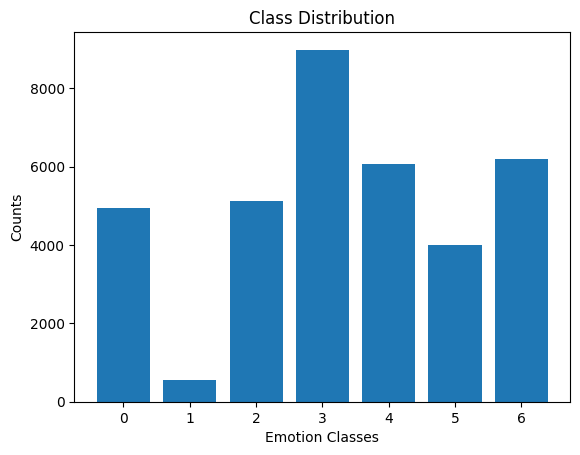

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Check class distribution
unique, counts = np.unique(emotions, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Emotion Classes')
plt.ylabel('Counts')
plt.title('Class Distribution')
plt.show()